# [Double-Hard Debias: Tailoring Word Embeddings for Gender Bias Mitigation](https://arxiv.org/abs/2005.00965)

For more detailed explanations, please refer to the paper.

### Load original embeddings

In [24]:
import codecs, os, json, operator, pickle
from random import shuffle
import numpy as np
from numpy import linalg as LA
import scipy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def load_glove(path):
    with open(path) as f:
        lines = f.readlines()
    
    wv = []
    vocab = []
    for line in lines:
        tokens = line.strip().split(" ")
        assert len(tokens) == 301
        vocab.append(tokens[0])
        wv.append([float(elem) for elem in tokens[1:]])
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.array(wv).astype(float)
    print(len(vocab), wv.shape, len(w2i))
    
    return wv, w2i, vocab

wv, w2i, vocab = load_glove('./data/vectors.txt')

322636 (322636, 300) 322636


### Restrict Vocabulary

In [99]:
import json
from tqdm import tqdm
from utils import limit_vocab


gender_specific = []
with open('./data/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('./data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

definitional_pairs = [['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], 
                      ['girl', 'boy'], ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], 
                      ['gal', 'guy'], ['female', 'male']]
definitional_words = []
for pair in definitional_pairs:
    for word in pair:
        definitional_words.append(word)

exclude_words = gender_specific
vocab_limit, wv_limit, w2i_limit = limit_vocab(wv, w2i, vocab, exclude = exclude_words)

100%|██████████| 50000/50000 [00:00<00:00, 303096.51it/s]


size of vocabulary: 47628


### Compute original bias

In [101]:
he_embed = wv[w2i['he'], :]
she_embed = wv[w2i['she'], :]

def simi(a, b):
    return 1-scipy.spatial.distance.cosine(a, b)

def compute_bias_by_projection(wv, w2i, vocab):
    d = {}
    for w in vocab:
        u = wv[w2i[w], :]
        d[w] = simi(u, he_embed) - simi(u, she_embed)
    return d

gender_bias_bef = compute_bias_by_projection(wv_limit, w2i_limit, vocab_limit)

### Debias

In [109]:
from sklearn.decomposition import PCA

# get main PCA components
def my_pca(wv):
    wv_mean = np.mean(np.array(wv), axis=0)
    wv_hat = np.zeros(wv.shape).astype(float)

    for i in range(len(wv)):
        wv_hat[i, :] = wv[i, :] - wv_mean

    main_pca = PCA()
    main_pca.fit(wv_hat)
    
    return main_pca

main_pca = my_pca(wv)
wv_mean = np.mean(np.array(wv), axis=0)

In [110]:
def hard_debias(wv, w2i, w2i_partial, vocab_partial, component_ids):
    
    D = []

    for i in component_ids:
        D.append(main_pca.components_[i])
    
    # get rid of frequency features
    wv_f = np.zeros((len(vocab_partial), wv.shape[1])).astype(float)
    
    for i, w in enumerate(vocab_partial):
        u = wv[w2i[w], :]
        sub = np.zeros(u.shape).astype(float)
        for d in D:
            sub += np.dot(np.dot(np.transpose(d), u), d)
        wv_f[w2i_partial[w], :] = wv[w2i[w], :] - sub - wv_mean
        
    # debias
    gender_directions = list()
    for gender_word_list in [definitional_pairs]:
        gender_directions.append(doPCA(gender_word_list, wv_f, w2i_partial).components_[0])
    
    wv_debiased = np.zeros((len(vocab_partial), len(wv_f[0, :]))).astype(float)
    for i, w in enumerate(vocab_partial):
        u = wv_f[w2i_partial[w], :]
        for gender_direction in gender_directions:
            u = drop(u, gender_direction)
            wv_debiased[w2i_partial[w], :] = u
    
    return wv_debiased

In [111]:
from sklearn.cluster import KMeans
def cluster_and_visualize(words, X, random_state, y_true, num=2):
    
    kmeans = KMeans(n_clusters=num, random_state=random_state).fit(X)
    y_pred = kmeans.predict(X)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred) ]
    preci = max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct)))
    print('precision', preci)
    
    return kmeans, y_pred, X, preci

In [118]:
from utils import extract_vectors
from utils import train_and_predict
from utils import doPCA, drop

size=1000
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]
y_true = [1]*size + [0]*size

c_vocab = list(set(male + female + [word for word in definitional_words if word in w2i]))
c_w2i = dict()
for idx, w in enumerate(c_vocab):
    c_w2i[w] = idx
    
precisions = []
    
for component_id in range(20):
    
    print('component id: ', component_id)
    
    wv_debiased = hard_debias(wv, w2i, w2i_partial = c_w2i, vocab_partial = c_vocab, component_ids = [component_id])
    _, _, _, preci = cluster_and_visualize(male + female, 
                                           extract_vectors(male + female, wv_debiased, c_w2i), 1, y_true)
    precisions.append(preci)
    

component id:  0
pairs used in PCA:  10
precision 0.817
component id:  1
pairs used in PCA:  10
precision 0.704
component id:  2
pairs used in PCA:  10
precision 0.8145
component id:  3
pairs used in PCA:  10
precision 0.816
component id:  4
pairs used in PCA:  10
precision 0.802
component id:  5
pairs used in PCA:  10
precision 0.775
component id:  6
pairs used in PCA:  10
precision 0.785
component id:  7
pairs used in PCA:  10
precision 0.8025
component id:  8
pairs used in PCA:  10
precision 0.807
component id:  9
pairs used in PCA:  10
precision 0.815
component id:  10
pairs used in PCA:  10
precision 0.812
component id:  11
pairs used in PCA:  10
precision 0.818
component id:  12
pairs used in PCA:  10
precision 0.8180000000000001
component id:  13
pairs used in PCA:  10
precision 0.8045
component id:  14
pairs used in PCA:  10
precision 0.8145
component id:  15
pairs used in PCA:  10
precision 0.811
component id:  16
pairs used in PCA:  10
precision 0.8145
component id:  17
pairs

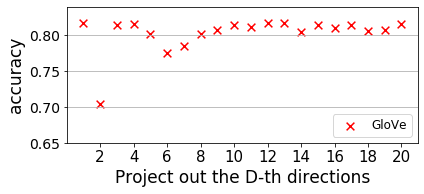

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(1, 21)
data1 = precisions

fig, ax1 = plt.subplots(figsize=(6,2.8))

color = 'red'
ax1.set_xlabel('Project out the D-th directions', fontsize=17)
ax1.set_ylabel('accuracy', fontsize=17)
ax1.scatter(t, data1, color=color, label='GloVe', marker = 'x', s=60)
plt.xticks([2,4,6,8,10, 12, 14, 16 ,18, 20], fontsize=15)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylim(0.65, 0.84)
ax1.legend(loc='lower right', frameon=True, fontsize='large')
ax1.grid(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()